#Eluvio Data Science Challenge

* The goal of this NLP project is to classify if the title is a high rated news or not.

* I will be using the columns up_votes and title from the dataset

* The up_votes greater than quantile 0.5 are high rated i.e; 1 and those lesser than that are low rated news i.e; 0

## Mounting the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import the modules

In [2]:
#modules for Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
#modules for plotting
import matplotlib.pyplot as plt
from tensorflow import keras
#modules for math
import pandas as pd
import json
import numpy as np
#modules for modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Read the data

In [13]:
url = "/content/drive/MyDrive/Eluvio- Data Science Intern/Data/Eluvio_DS_Challenge.csv" 
df = pd.read_csv(url, header = 0) 
df = pd.DataFrame(df)
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   time_created  509236 non-null  int64 
 1   date_created  509236 non-null  object
 2   up_votes      509236 non-null  int64 
 3   down_votes    509236 non-null  int64 
 4   title         509236 non-null  object
 5   over_18       509236 non-null  bool  
 6   author        509236 non-null  object
 7   category      509236 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


In [15]:
#check that no columns have null values
df.isnull().sum()

time_created    0
date_created    0
up_votes        0
down_votes      0
title           0
over_18         0
author          0
category        0
dtype: int64

## Exploring Columns

* The column 'category' has only one value - worldnews
* The column 'down_votes' has all Zeros
* Lets look at top 5 authors who received highest up_votes

In [16]:
top5_authors = df.nlargest(5, ['up_votes'])
top5_authors[['author','up_votes']].reset_index(drop=True)


,author,up_votes
0,KRISHNA53,21253
1,joeyoungblood,13435
2,mister_geaux,13244
3,navysealassulter,12333
4,seapiglet,11288


* Here are the 5 authors with highest up_votes
  * KRISHNA53
  * joeyoungblood
  * mister_geaux
  * navysealassulter
  * seapiglet

## Data Pre-processing

* Since the columns **up_votes** and **title** have a strong correlation, we will classify the title into **high rated** and **low rated** based on up_votes.
* The title with top 50 percentile of the up_votes is considered to be **high rated** and the other is **low rated**
* The high rated group is labelled 1 and the low rated group is 0


In [17]:
high_rate = np.quantile(df['up_votes'], 0.5)
df['news_rating'] = np.where(df['up_votes']>= high_rate, 1, 0)
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,news_rating
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews,0
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews,0
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews,0
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews,0
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews,0


In [18]:
#convert title to lower case
df['title'] = df['title'].str.lower()
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,news_rating
0,1201232046,2008-01-25,3,0,scores killed in pakistan clashes,False,polar,worldnews,0
1,1201232075,2008-01-25,2,0,japan resumes refuelling mission,False,polar,worldnews,0
2,1201232523,2008-01-25,3,0,us presses egypt on gaza border,False,polar,worldnews,0
3,1201233290,2008-01-25,1,0,jump-start economy: give health care to all,False,fadi420,worldnews,0
4,1201274720,2008-01-25,4,0,council of europe bashes eu&un terror blacklist,False,mhermans,worldnews,0


In [19]:
# replace any special characters with a blank
df['title'] = df['title'].str.replace('[^A-z ]','').str.replace(' +',' ').str.strip()
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,news_rating
0,1201232046,2008-01-25,3,0,scores killed in pakistan clashes,False,polar,worldnews,0
1,1201232075,2008-01-25,2,0,japan resumes refuelling mission,False,polar,worldnews,0
2,1201232523,2008-01-25,3,0,us presses egypt on gaza border,False,polar,worldnews,0
3,1201233290,2008-01-25,1,0,jumpstart economy give health care to all,False,fadi420,worldnews,0
4,1201274720,2008-01-25,4,0,council of europe bashes euun terror blacklist,False,mhermans,worldnews,0


* Lets look at a graph for the new column "news_rating" that we created based on up_votes
* We have a balanced dataset for both the groups

In [20]:
df['news_rating'].value_counts()

1    258838
0    250398
Name: news_rating, dtype: int64

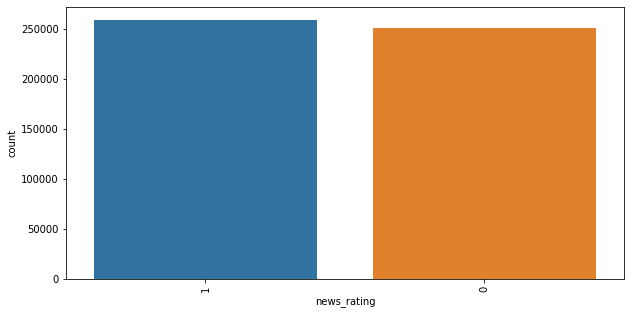

In [21]:
# plotting
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
ax = sns.countplot(x="news_rating", data=df,
                   order = df['news_rating'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

### Tokenizer

* The tokenizer takes a given sentence and parses it into a list with individual words separated by a comma. This makes it easier for us to do some feature engineering

### Stop Words

* I introduce stop words to improve the performance of the models and remove them from title

* I downloaded the stopwords from nltk.corpus and extracted the stop words 

* I then applied these stop words to our data to see if the models behave any differently

* I also created some EDA to observe top 20 words with their frequencies

* I plotted frequency distribution graph and word cloud to visualy display the top words



In [22]:
# let's remove some of the stop words
# define some stop words
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords') 
print(stopwords.words('english'))

stop = stopwords.words('english') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'bo

In [23]:
df.head() # note how the stop words have been removed
df["title"] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) 
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,news_rating
0,1201232046,2008-01-25,3,0,scores killed pakistan clashes,False,polar,worldnews,0
1,1201232075,2008-01-25,2,0,japan resumes refuelling mission,False,polar,worldnews,0
2,1201232523,2008-01-25,3,0,us presses egypt gaza border,False,polar,worldnews,0
3,1201233290,2008-01-25,1,0,jumpstart economy give health care,False,fadi420,worldnews,0
4,1201274720,2008-01-25,4,0,council europe bashes euun terror blacklist,False,mhermans,worldnews,0


### EDA

In [24]:
TopWords = df['title'].str.split(expand=True).stack().value_counts()
TopWords[0:20]

us            39583
says          25395
china         24481
new           23312
syria         18291
russia        17413
world         16598
police        16555
government    15171
israel        15021
iran          14887
president     14575
killed        14313
people        13749
attack        12803
state         12502
un            12306
war           12299
uk            11889
military      11625
dtype: int64

In [25]:
# we can make a frequency plot 
# we'll group, then convert to pandas DataFrame for easy plotting
x = df['title'].str.split(expand=True).stack().value_counts()
x = pd.DataFrame(x)
# reset the index
x.reset_index(inplace=True)
# rename the columns
x.rename(columns={x.columns[0]:'word', x.columns[1]:'frequency'}, inplace=True)
x.head()

,word,frequency
0,us,39583
1,says,25395
2,china,24481
3,new,23312
4,syria,18291


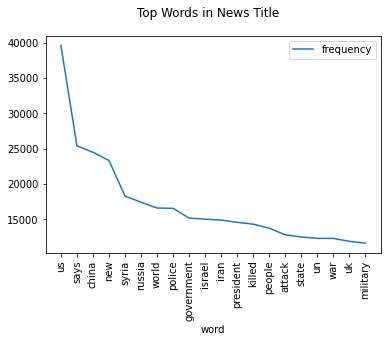

In [26]:
# Frequency Distribution Plot
# look at first X words
x = x[0:20]
x.plot(x='word', y='frequency')
plt.xticks(np.arange(len(x)), x['word'], rotation=90)
plt.suptitle('Top Words in News Title')
plt.show()


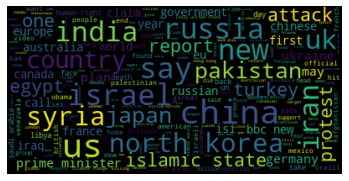

In [27]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud().generate(' '.join(df['title']))

# Display the generated image:
wordcloud = WordCloud(max_font_size=40).generate(' '.join(df['title']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Tokenize title

In [28]:
# import
nltk.download('punkt')
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
#tokenize title using nltk.word
df['title'] = df.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,news_rating
0,1201232046,2008-01-25,3,0,"[scores, killed, pakistan, clashes]",False,polar,worldnews,0
1,1201232075,2008-01-25,2,0,"[japan, resumes, refuelling, mission]",False,polar,worldnews,0
2,1201232523,2008-01-25,3,0,"[us, presses, egypt, gaza, border]",False,polar,worldnews,0
3,1201233290,2008-01-25,1,0,"[jumpstart, economy, give, health, care]",False,fadi420,worldnews,0
4,1201274720,2008-01-25,4,0,"[council, europe, bashes, euun, terror, blackl...",False,mhermans,worldnews,0


### Delete unwanted columns

In [30]:
# delete the columns other than 'title' and 'news_rating'
del df['author']
del df['category']
del df['date_created']
del df['down_votes']
del df['over_18']
del df['time_created']
del df['up_votes']

In [31]:
df.head()

,title,news_rating
0,"[scores, killed, pakistan, clashes]",0
1,"[japan, resumes, refuelling, mission]",0
2,"[us, presses, egypt, gaza, border]",0
3,"[jumpstart, economy, give, health, care]",0
4,"[council, europe, bashes, euun, terror, blackl...",0


### Rejoin the words in title to prepare data for Modeling

In [32]:
def rejoin_words(row):
    my_list = row['title']
    joined_words = ( " ".join(my_list))
    return joined_words

df['title'] = df.apply(rejoin_words, axis=1)
# here it is after - no square brackets and commas!
df['title'].head()

0                 scores killed pakistan clashes
1               japan resumes refuelling mission
2                   us presses egypt gaza border
3             jumpstart economy give health care
4    council europe bashes euun terror blacklist
Name: title, dtype: object

## Splitting the data into X and y

* Splitting the dataset into X and y
* 80/20 split into train and test samples 

In [33]:
X = pd.DataFrame(df['title'])
y = df['news_rating']

In [34]:
X.head()

,title
0,scores killed pakistan clashes
1,japan resumes refuelling mission
2,us presses egypt gaza border
3,jumpstart economy give health care
4,council europe bashes euun terror blacklist


In [35]:
print(X.shape)
print(y.shape)

(509236, 1)
(509236,)


In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

# get rid of garbage text
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

#tokenizer to remove unwanted elements from out data like symbols and numbers
cv = CountVectorizer(lowercase=True,
                     stop_words='english',
                     #using unigram
                     ngram_range = (1,1), # (1,1) is unigram, (1,2) is uni and bigram, (2,2) is just bigram
                     tokenizer = token.tokenize)
text_counts= cv.fit_transform(X['title']) 
print(text_counts.shape)

(509236, 107179)


In [37]:
# inspect text_counts
# check out the first row
print(text_counts)
np.sum(text_counts[1]) # number of entries

  (0, 84233)	1
  (0, 51361)	1
  (0, 69359)	1
  (0, 17998)	1
  (1, 48794)	1
  (1, 80160)	1
  (1, 78833)	1
  (1, 60729)	1
  (2, 74361)	1
  (2, 28748)	1
  (2, 37298)	1
  (2, 12115)	1
  (3, 49913)	1
  (3, 28419)	1
  (3, 41814)	1
  (3, 15144)	1
  (4, 20950)	1
  (4, 30929)	1
  (4, 9014)	1
  (4, 31033)	1
  (4, 94985)	1
  (4, 11059)	1
  (5, 41625)	2
  (5, 74404)	1
  (5, 33052)	1
  :	:
  (509232, 70947)	1
  (509232, 56313)	1
  (509232, 58341)	1
  (509232, 89679)	1
  (509233, 5660)	1
  (509233, 7600)	1
  (509233, 74928)	1
  (509233, 78183)	1
  (509233, 79892)	1
  (509234, 7043)	1
  (509234, 80070)	1
  (509234, 3536)	1
  (509234, 97987)	1
  (509234, 98594)	1
  (509234, 64978)	1
  (509234, 32996)	1
  (509235, 8589)	1
  (509235, 48088)	1
  (509235, 23390)	1
  (509235, 69487)	1
  (509235, 72841)	1
  (509235, 86798)	1
  (509235, 104023)	1
  (509235, 51775)	1
  (509235, 104429)	1


4

In [38]:
# partition into 80/20 train and test samples 
X_train, X_test, y_train, y_test = train_test_split(text_counts, y, test_size=0.2, random_state=1)


In [39]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(407388, 107179)
(407388,)
(101848, 107179)
(101848,)


## Modeling

### Decision Tree Classifier

In [40]:
from sklearn.tree import DecisionTreeClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Generation Using Decision Tree Classifier
clf = DecisionTreeClassifier().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("Decision Tree Classifier Accuracy:",metrics.accuracy_score(y_test, predicted))

Decision Tree Classifier Accuracy: 0.5487687534364936


#### Evaluate the Model
* Classification Report 
* Confusion Matrix

In [41]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.54      0.57      0.55     50009
           1       0.56      0.53      0.55     51839

    accuracy                           0.55    101848
   macro avg       0.55      0.55      0.55    101848
weighted avg       0.55      0.55      0.55    101848



In [42]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted) 

array([[28259, 21750],
       [24207, 27632]])

### Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Generation Using Logistic Regression
clf = LogisticRegression(max_iter = 1000).fit(X_train,y_train)
predicted= clf.predict(X_test)
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))

Logistic Regression Accuracy: 0.5933449846830571


#### Evaluate the Model
* Classification Report 
* Confusion Matrix

In [45]:
from sklearn import metrics
from sklearn.metrics import accuracy_score

#Classification_report
classification_report = metrics.classification_report(y_test,predicted)
print(classification_report)

              precision    recall  f1-score   support

           0       0.58      0.61      0.59     50009
           1       0.60      0.58      0.59     51839

    accuracy                           0.59    101848
   macro avg       0.59      0.59      0.59    101848
weighted avg       0.59      0.59      0.59    101848



In [46]:
#Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test,predicted)
print(confusion_matrix)

# top left is TN
# bottom left is FN
# top right is FP
# bottom right is TP

[[30396 19613]
 [21804 30035]]


### Multinomial Naive Bayes

In [47]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train,y_train)
predicted = clf.predict(X_test)
print("Multinomial Naive Bayes Accuracy:",metrics.accuracy_score(y_test, predicted))

Multinomial Naive Bayes Accuracy: 0.5849403031969209


#### Evaluate the Model
* Classification Report 
* Confusion Matrix

In [48]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.58      0.57      0.58     50009
           1       0.59      0.59      0.59     51839

    accuracy                           0.58    101848
   macro avg       0.58      0.58      0.58    101848
weighted avg       0.58      0.58      0.58    101848



In [49]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted) 

array([[28739, 21270],
       [21003, 30836]])

## Create features for Modeling using TF-IDF method

* Since the models are not performing that well, I wanted to see if TF-IDF method to create the features would improve the performance of the models
* TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.
* TF(w) = (Number of times term w appears in a document) / (Total number of terms in the document)
* IDF(w) = log_e(Total number of documents / Number of documents with term w in it)
*TF-IDF (term frequency, inverse document frequency) is the product of these two quantities
* TF-IDF(Term Frequency-Inverse Document Frequency) normalizes the document term matrix. It is the product of TF and IDF. Word with high tf-idf in a document, it is most of the times occurred in given documents and must be absent in the other documents. So the words must be a signature word.


In [50]:
# create the matrix
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
text_tf= tf.fit_transform(X['title'])

In [51]:
# check out what you did
text_tf.shape 

(509236, 107441)

In [52]:
print(text_tf[0])

  (0, 18057)	0.531470789910242
  (0, 69525)	0.4199903049291642
  (0, 51482)	0.3716004284523815
  (0, 84404)	0.6348701164897411


In [53]:
# split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text_tf, y, 
                                                    test_size=0.2, random_state=123)

### Decision Tree Classifier

In [66]:
# fit a model
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
clf = DecisionTreeClassifier().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("Decision Tree Classifier Accuracy:",metrics.accuracy_score(y_test, predicted))


Decision Tree Classifier Accuracy: 0.5419644961118529


####Evaluate the Model
* Classification Report
* Confusion Matrix

In [67]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.53      0.55      0.54     49989
           1       0.55      0.54      0.54     51859

    accuracy                           0.54    101848
   macro avg       0.54      0.54      0.54    101848
weighted avg       0.54      0.54      0.54    101848



In [68]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted) 

array([[27280, 22709],
       [23941, 27918]])

### Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Generation Using Logistic Regression
clf = LogisticRegression(max_iter = 1000).fit(X_train,y_train)
predicted= clf.predict(X_test)
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))

Logistic Regression Accuracy: 0.6043515827507658


#### Evaluate the Model
* Classification Report 
* Confusion Matrix

In [64]:
from sklearn import metrics
from sklearn.metrics import accuracy_score

#Classification_report
classification_report = metrics.classification_report(y_test,predicted)
print(classification_report)

              precision    recall  f1-score   support

           0       0.60      0.59      0.59     49989
           1       0.61      0.62      0.61     51859

    accuracy                           0.60    101848
   macro avg       0.60      0.60      0.60    101848
weighted avg       0.60      0.60      0.60    101848



In [65]:
#Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test,predicted)
print(confusion_matrix)

# top left is TN
# bottom left is FN
# top right is FP
# bottom right is TP

[[29507 20482]
 [19814 32045]]


### Multinomial Naive Bayes

In [58]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train,y_train)
predicted = clf.predict(X_test)
print("Multinomial Naive Bayes Accuracy:",metrics.accuracy_score(y_test, predicted))

Multinomial Naive Bayes Accuracy: 0.5865800015709685


#### Evaluate the Model
* Classification Report 
* Confusion Matrix

In [59]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.59      0.50      0.54     49989
           1       0.58      0.67      0.62     51859

    accuracy                           0.59    101848
   macro avg       0.59      0.58      0.58    101848
weighted avg       0.59      0.59      0.58    101848



In [60]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted) 

array([[24766, 25223],
       [16883, 34976]])

## Model Comparison

**Model**                                     |    **Accuracy**        |
----------------------------------------------|------------------------|
**Model 1: Decision Tree Classifier**         |      0.5488            |
**Model 2: Logistic Regression**              |      0.5933            |
**Model 3: Multinomial Naive Bayes**          |      0.5850            |
**Model 4: Decision Tree Classifier(TF-IDF)** |      0.5420            |
**Model 5: Logistic Regression(TF-IDF)**      |      0.6044            |
**Model 6: Multinomial Naive Bayes(TF-IDF)**  |      0.5866            |



I decided the best model based on Accuracy, Complexity and Explanability

### Accuracy
Top 3 models based on Accuracy are as follows:

**Model**                                     |    **Accuracy**        |
----------------------------------------------|------------------------|
**Model 5: Logistic Regression(TF-IDF)**      |      0.6044            |
**Model 2: Logistic Regression**              |      0.5933            |
**Model 6: Multinomial Naive Bayes(TF-IDF)**  |      0.5866            |




### Complexity
* I used two methods for feature extraction- Tokenizer and TF-IDF.
Logistic Regression with TF-IDF method for creating features performed the best with 60.44% accuracy rate followed by Logistic Regression with Tokenizer and Multinomial Naive Bayes (TF-IDF) with an accuracy of 59.33% and 58.66% respectively.
* Overall, I observed that TF-IDF method of creating features for models yielded better accuracy rates. However, Decision Tree Classifier performed better with Tokenizer method with an accuracy of 54.88%.
* I also noticed that Decision Tree Classifier models took longer to run when compared to Logistic Regression and Multinomial Naive Bayes models, making the other two more attractive and time consuming.


## Conclusion
* As the dataset is large, I used the power of Tokenizer that makes it easier for feature engineering.
* I also used TF-IDF method which is a glorified form of feature engineering to create features for modeling.
* I got the best model when I used TF-IDF method on Logistic Regression with max_iterations = 1000 which gave an accuracy rate of 60.44%
* Overall, the models had better performance when TF-IDF method was used for feature engineering
* The title is the best column to classify if the news has received more number of up_votes or not. 